In [17]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

at above we import all the libraries requaredaa

linklist  ##

22 -> 90 -> 59 -> 75 -> 70 -> 9 -> 

9
75
22 -> 90 -> 59 -> 75 -> 70 -> 9 -> 

#################
linklist  ##


In [ ]:
def data_labeling(img_files, txt_path):
    full_data = []
    cordinates = []
    # count_cancer = 0
    # img_coordinate = defaultdict(list)
    
    for i, filename in enumerate(sorted(os.listdir(img_files))): # Open the image file and go throuth all the image 
        if filename.endswith(".pgm"): # display only if the image is pgm
            image_path = os.path.join(img_files, filename) # Getting the Image path EX => all-mias\mdb001.pgm
            text = txt_file[i].strip() # spliting the data in the text file 

            pairing = {"Image": image_path, "Text": text} # putting both image and the text in the dictinory 
            # print(pairing)
            full_data.append(pairing) # adding all the data to the list 
            # print(full_data)

    for pairing in full_data:
        txt_value = pairing['Text'] # ceperating the image with the text
        img_value = pairing['Image']
        img = cv2.imread(img_value) # creating the array
        # print(f"YHE IMG {img} ")
        txt_parts = txt_value.split() # spleting text in to multiple in array so to filter the data which they have the cordinates
        # print(f" === {txt_parts[2]}")
        # cordinate = {}
        
        img_gray = cv2.imread(img_value, cv2.IMREAD_GRAYSCALE) # Converting the image to GRAY and then to RGB
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        # print(f" Image Value {img_rgb}")
        
        ##### Error is in adding all the cordinate to the array and repating the circle
        if len(txt_parts) == 7 and img is not None: # filtring the text and the imge
            # count_cancer += 1
            get_txt_data = txt_parts[4] + " " + txt_parts[5] + " " +txt_parts[6] # joining the X , Y , R
            numbers_list = list(map(int, get_txt_data.split())) # list of all the cordinate we want  EX => [535, 425, 197]
            # print(txt_parts[0])
            cordinates.append(numbers_list)
            # print(numbers_list)

            
            sorted_mdb = sorted(cordinates, key=lambda item: item[-1])
            for x, y, r in sorted_mdb:
                y_adj = 1024 - y  # adjust y-coordinate
                cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 2)

        if sorted_mdb:
            x, y, r = sorted_mdb[0]
            y_adj = 1024 - y
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y_adj), r, 255, -1)
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)


        plt.imshow(img_rgb, cmap='gray')
        plt.title("Example .pgm Image")
        plt.axis('off')  # Hide axis ticks
        plt.show()
        


# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]

data_labeling(images_path, txt_path)


In [30]:
class Node:
    def __init__(self, value, next_node=None):
        self.value = value
        
        self.next_node = next_node
    def get_value(self):
        return self.value
        
    def get_next_node(self):
        return self.next_node
        
    def set_next_node(self, next_node):
        self.next_node = next_node

class LinkedList:
    def __init__(self, value=None):
        self.head_node = Node(value) #seting the head_node as the first value of the Node
    def get_head_node(self):
        return self.head_node # Getting the location of the head_node since in the __init__ method we declear a head_node as the first node
    
    def insert_beginning(self, new_value):
        new_node = Node(new_value) #setting the new_node as the new_value of the Node same as a Head_node
        new_node.set_next_node(self.head_node) # adding the new_node to the Link List so whatever is 
                                                                #head_node is at the moment new_node with be a new head_node
        self.head_node = new_node # again putting the head_node pointer as the first node                        

    def stringfy_list(self):
        string_list = "" # saving all the Node in the string list
        current_node = self.get_head_node()# get the head_node as current node
        while current_node: # see if the current_node in None or not
            if current_node.get_value() != None:
                string_list += str(current_node.get_value()) + ' -> ' # adding the node to string_list until the pointer get to None
            current_node = current_node.get_next_node() # connectin the node with each other in link list
        return string_list
    
    def remove_node(self, node_to_remove): 
        current_node = self.get_head_node() # again getting the current_node as a head_node
        if current_node.get_value() == node_to_remove:
            self.head_node = current_node.get_next_node() # remove the node if its the first node
        else:
            while current_node: # As long as current_node is None
                next_node = current_node.get_next_node()# presenting the next_node, a node after the head_node
                if next_node.get_value() == node_to_remove: # check if the next_node is the node we need to remove 
                    current_node.set_next_node(next_node.get_next_node()) # if yest cunnect the perv node to next_node 
                    current_node = None # end the loop
                else:
                   current_node = next_node # if the first next_node is not the node we need to remove and move both pointer one ahead so:
                '''
    if right now our current node is on 22 and next_node is on 90  by adding the last else
    now our pointer for the current node is 90 and our next node is 59
        22 --> 90 --> 59 --> 75 --> 70 --> 5 --> None
                '''
    def twoin_pointer(self):
        first_pointer = self.head_node
        second_pointer = self.head_node

        while first_pointer and first_pointer.get_next_node():
            first_pointer = first_pointer.get_next_node()
            if first_pointer.get_next_node():
                first_pointer = first_pointer.get_next_node()
                second_pointer = second_pointer.get_next_node()
        # print(f" the first pointer is {first_pointer.get_value()} and the second pointer is {second_pointer.get_value()}")
        return first_pointer, second_pointer

    def node_ceperation(self, n):
        second_node = None
        first_node = self.get_head_node()
        count = 0

        while first_node:
            
            first_node = first_node.get_next_node()
            count +=1

            if count >= n+1:
                if second_node is None:
                    second_node = self.get_head_node()
                else:
                    second_node = second_node.get_next_node()
        return second_node



ll = LinkedList(9) #adding the new node to the LinkList
ll.insert_beginning(70)
ll.insert_beginning(75)
ll.insert_beginning(59)
ll.insert_beginning(90)
ll.insert_beginning(22)
print("linklist  ##"+ '\n')
print(ll.stringfy_list() + '\n')

first, second = ll.twoin_pointer()
print(first.value)
print(ll.node_ceperation(2).value)
print(ll.stringfy_list() + '\n')
print("#################")
print("linklist  ##")

linklist  ##

22 -> 90 -> 59 -> 75 -> 70 -> 9 -> 

9
75
22 -> 90 -> 59 -> 75 -> 70 -> 9 -> 

#################
linklist  ##


In [81]:
def data_labeling(img_files, txt_path):
    full_data = []
    count_cancer = 0
    img_coordinate = defaultdict(list)
    pgm_index = 0
    for i, filename in enumerate(sorted(os.listdir(img_files))):
        if filename.endswith(".pgm"):
            image_path = os.path.join(img_files, filename)
            text = txt_file[i].strip()
            pairing = {"Image": image_path, "Text": text}
            pgm_index += 1
            full_data.append(pairing)
        else:
            print(f"Not enough line in {filename}")
    
    for pairing in full_data:
        txt_value = pairing['Text']
        img_value = pairing['Image']
        img = cv2.imread(img_value)
        txt_parts = txt_value.split()

        if len(txt_parts) == 7 and img is not None:
            count_cancer += 1
            get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " +txt_parts[6] + " - " +img_value[9:]
            # print(" x      y    R")
            print(get_txt_data)
            
            x = int(txt_parts[4])
            y = 1024 - int(txt_parts[5])
            radius = int(txt_parts[6])

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
            # Create a mask for the circular ROI
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y), radius, 255, -1)  # Fill the circle with white
            # Extract the circular ROI using the mask
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    #         plt.imshow(img_rgb)
    #         plt.show()

        
# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]

data_labeling(images_path, txt_path)

535 - 425 - 197 - mdb001.pgm
522 - 280 - 69 - mdb002.pgm
500 - 145 - 60 - mdb005.pgm
525 - 425 - 33 - mdb010.pgm
471 - 458 - 40 - mdb012.pgm
667 - 365 - 31 - mdb013.pgm
595 - 864 - 68 - mdb015.pgm
547 - 573 - 48 - mdb017.pgm
653 - 477 - 49 - mdb019.pgm
493 - 125 - 49 - mdb021.pgm
538 - 681 - 29 - mdb023.pgm
674 - 443 - 79 - mdb025.pgm
338 - 314 - 56 - mdb028.pgm
322 - 676 - 43 - mdb030.pgm
388 - 742 - 66 - mdb032.pgm
318 - 359 - 27 - mdb058.pgm
546 - 463 - 33 - mdb063.pgm
462 - 406 - 44 - mdb069.pgm
266 - 517 - 28 - mdb072.pgm
468 - 717 - 23 - mdb075.pgm
432 - 149 - 20 - mdb080.pgm
492 - 473 - 131 - mdb081.pgm
544 - 194 - 38 - mdb083.pgm
510 - 547 - 49 - mdb090.pgm
680 - 494 - 20 - mdb091.pgm
423 - 662 - 43 - mdb092.pgm
466 - 517 - 29 - mdb095.pgm
612 - 297 - 34 - mdb097.pgm
714 - 340 - 23 - mdb099.pgm
415 - 460 - 38 - mdb102.pgm
357 - 365 - 50 - mdb104.pgm
516 - 279 - 98 - mdb105.pgm
600 - 621 - 111 - mdb107.pgm
190 - 427 - 51 - mdb110.pgm
505 - 575 - 107 - mdb111.pgm
461 - 532 - 117 

In [80]:
def data_labeling(img_files, txt_path):
    full_data = []
    count_cancer = 0
    pgm_index = 0  # This will index into txt_file
    
    # Loop through image files sorted by name
    for filename in sorted(os.listdir(img_files)):
        if filename.endswith(".pgm"):
            image_path = os.path.join(img_files, filename)
            
            # Check if we have a corresponding text line
            if pgm_index < len(txt_file):
                text = txt_file[pgm_index].strip()
            else:
                print(f"Warning: Not enough text lines for {filename}")
                text = ""  # or handle the error as needed
            
            pairing = {"Image": image_path, "Text": text}
            full_data.append(pairing)
            pgm_index += 1  # increment only when a .pgm file is processed

    # Process each pairing
    for pairing in full_data:
        txt_value = pairing['Text']
        img_value = pairing['Image']
        img = cv2.imread(img_value)
        txt_parts = txt_value.split()

        if len(txt_parts) == 7 and img is not None:
            count_cancer += 1
            get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " + txt_parts[6] + " - " + img_value[9:]
            print(get_txt_data)
            
            x = int(txt_parts[4])
            y = 1024 - int(txt_parts[5])
            radius = int(txt_parts[6])

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y), radius, 255, -1)
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
            # Optionally display the image:
            # plt.imshow(img_rgb)
            # plt.show()

# Reading the image files
images_path = "all-mias"

# Reading the text file and skipping the header
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]  # Skip the header line

data_labeling(images_path, txt_path)


535 - 425 - 197 - mdb001.pgm
522 - 280 - 69 - mdb002.pgm
500 - 145 - 60 - mdb005.pgm
525 - 425 - 33 - mdb010.pgm
471 - 458 - 40 - mdb012.pgm
667 - 365 - 31 - mdb013.pgm
595 - 864 - 68 - mdb015.pgm
547 - 573 - 48 - mdb017.pgm
653 - 477 - 49 - mdb019.pgm
493 - 125 - 49 - mdb021.pgm
538 - 681 - 29 - mdb023.pgm
674 - 443 - 79 - mdb025.pgm
338 - 314 - 56 - mdb028.pgm
322 - 676 - 43 - mdb030.pgm
388 - 742 - 66 - mdb032.pgm
318 - 359 - 27 - mdb058.pgm
546 - 463 - 33 - mdb063.pgm
462 - 406 - 44 - mdb069.pgm
266 - 517 - 28 - mdb072.pgm
468 - 717 - 23 - mdb075.pgm
432 - 149 - 20 - mdb080.pgm
492 - 473 - 131 - mdb081.pgm
544 - 194 - 38 - mdb083.pgm
510 - 547 - 49 - mdb090.pgm
680 - 494 - 20 - mdb091.pgm
423 - 662 - 43 - mdb092.pgm
466 - 517 - 29 - mdb095.pgm
612 - 297 - 34 - mdb097.pgm
714 - 340 - 23 - mdb099.pgm
415 - 460 - 38 - mdb102.pgm
357 - 365 - 50 - mdb104.pgm
516 - 279 - 98 - mdb105.pgm
600 - 621 - 111 - mdb107.pgm
190 - 427 - 51 - mdb110.pgm
505 - 575 - 107 - mdb111.pgm
461 - 532 - 117 

In [58]:
## FINDING THE REPEATED CORDINATION

def data_labeling(img_files, txt_path):
    full_data = []
    count_cancer = 0
    text_count = defaultdict(int)

    # Reading image file paths and corresponding text values
    for i, filename in enumerate(sorted(os.listdir(img_files))):
        if filename.endswith(".pgm"):
            image_path = os.path.join(img_files, filename)
            text = txt_file[i].strip()

            pairing = {"Image": image_path, "Text": text}
            full_data.append(pairing)

    # Iterate through the full_data, process each image and extract coordinates
    for pairing in full_data:
        txt_value = pairing['Text']
        img_value = pairing['Image']
        img = cv2.imread(img_value)
        txt_parts = txt_value.split()
        tokens = pairing['Text'].split()
        txt_key = tokens[0]
        text_count[txt_key] += 1
    coordinates_dict = defaultdict(list)
    
    for entry in full_data:
        tokens = entry['Text'].split()
        if len(tokens) > 3:
            txt_key = tokens[0]  # Extract text key
            # print(txt_key)
            if text_count[txt_key] > 1:  # Only consider repeated text keys
                coords = list(map(int, tokens[-3:]))  # Extract last three as coordinates
                coordinates_dict[txt_key].append(coords)

    for key, coords in coordinates_dict.items():
        print(f"{key}: {coords}")

# Reading the image file paths
images_path = "all-mias"

# Reading the txt file
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()

# Run the data labeling function
data_labeling(images_path, txt_path)


   REFNUM BG CLASS SEVERITY      X      Y  RADIUS
0  mdb001  G  CIRC        B  535.0  425.0   197.0
1  mdb002  G  CIRC        B  522.0  280.0    69.0
2  mdb003  D  NORM      NaN    NaN    NaN     NaN
3  mdb004  D  NORM      NaN    NaN    NaN     NaN
4  mdb005  F  CIRC        B  477.0  133.0    30.0


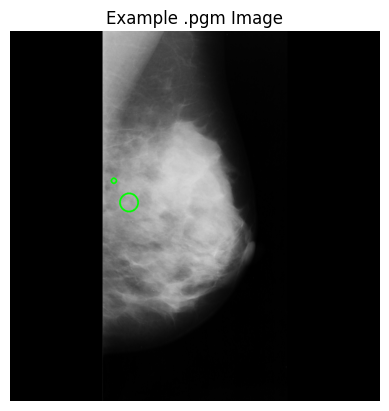

In [42]:
# Read the image file
img_file = "all-mias/mdb226.pgm"
img_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

# Read the text file
with open("info.txt", "r") as file:
    txt_lines = file.readlines()

# Read the CSV file
df = pd.read_csv("Info.txt", sep=" ").drop("Unnamed: 7", axis=1)
print(df.head(5))

# Example data: list of [x, y, radius]
mdb144 = [[287, 610, 7], [329, 550, 25]]
# Sort by the last element (assumed to be the radius)
sorted_mdb = sorted(mdb144, key=lambda item: item[-1])

# Draw a circle for each detection
for x, y, r in sorted_mdb:
    y_adj = 1024 - y  # adjust y-coordinate
    cv2.circle(img_rgb, (x, y_adj), r, (0, 255, 0), 3)

# Create a mask and region of interest using the first detection (if available)
if sorted_mdb:
    x, y, r = sorted_mdb[0]
    y_adj = 1024 - y
    mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y_adj), r, 255, -1)
    roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# Display the result
plt.imshow(img_rgb, cmap='gray')
plt.title("Example .pgm Image")
plt.axis('off')  # Hide axis ticks
plt.show()


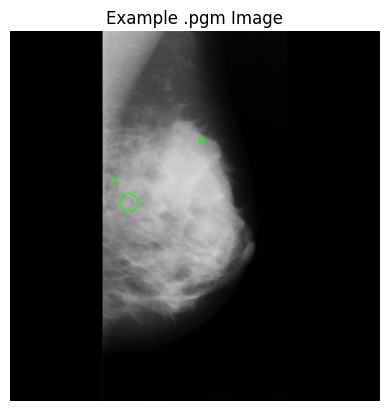

In [33]:
# reading the Image file 
# img_files = glob.glob("all-mias")
img_files_test = "all-mias/mdb226.pgm"
# print(f"found {len(img_files)} .pmg images")

# reading the txt file 
txt_path = "info.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()

df = pd.read_csv('Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

    
img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)
# x, y, radius = 535, 425, 197
# custom_list = {}
mdb144 = [[287, 610, 7], [329, 550, 25], [531, 721, 8]]
# mdb144 = [[233, 994, 29], [313, 540, 27]]
# mdb144 = [[522, 280, 69]]


if len(mdb144) == 1:
    sorted_mdb = sorted(mdb144, key= lambda item: item[-1])
    x, y, r = mdb144[0]
    y = 1024 - y
    cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
    mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)
    roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

    plt.imshow(img_rgb_t, cmap='gray')
    plt.title("Example .pgm Image")
    plt.axis('off')  # Hide axis ticks
    plt.show()

elif len(mdb144) == 2:
    sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
    for i in range(len(sorted_mdb)):
        x, y, r = sorted_mdb[i]
        y = 1024-y
        if len(sorted_mdb) > 1:
            x2, y2, r2 = sorted_mdb[0]
            y2 = 1024-y2
    cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
    cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2) 
    mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)
    roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

    plt.imshow(img_rgb_t, cmap='gray')
    plt.title("Example .pgm Image")
    plt.axis('off')  # Hide axis ticks
    plt.show()

elif len(mdb144) == 3:
    sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
    for i in range(len(sorted_mdb)):
        x, y, r = sorted_mdb[i]
        y = 1024-y
        if len(sorted_mdb) > 1:
            x2, y2, r2 = sorted_mdb[1]
            y2 = 1024-y2
            x3, y3, r3 = sorted_mdb[0]
            y3 = 1024-y3
    cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
    cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2)
    cv2.circle(img_rgb_t, (x3,y3), r3, (0, 255, 0), 2)
    mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)
    roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

    plt.imshow(img_rgb_t, cmap='gray')
    plt.title("Example .pgm Image")
    plt.axis('off')  # Hide axis ticks
    plt.show()


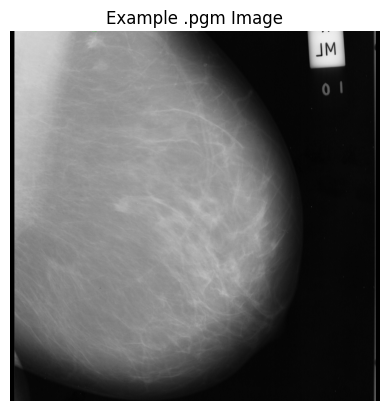

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read image file
img_files_test = "all-mias/mdb144.pgm"
img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)

# Example mdb144 data (x, y, radius)
mdb144 = [[233, 994, 29], [313, 540, 27]]

# Sort list by the y-coordinate (second element)
sorted_mdb = sorted(mdb144, key=lambda item: item[1])

# Process the first sublist
if len(sorted_mdb) >= 1:
    x, y, r = sorted_mdb[0]
    y_adj = y - 1024  # Adjust y-coordinate if necessary
    cv2.circle(img_rgb_t, (x, y_adj), r, (0, 255, 0), 2)
    # Overlay coordinate text
    cv2.putText(img_rgb_t, f"({x}, {y_adj})", (x, y_adj), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Process the second sublist if available
if len(sorted_mdb) >= 2:
    x2, y2, r2 = sorted_mdb[1]
    y2_adj = y2 - 1024  # Adjust y-coordinate if necessary
    cv2.circle(img_rgb_t, (x2, y2_adj), r2, (0, 255, 0), 2)
    # Overlay coordinate text
    cv2.putText(img_rgb_t, f"({x2}, {y2_adj})", (x2, y2_adj), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Create a mask using the first circle's parameters (if needed)
mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
cv2.circle(mask, (x, y - 1024), r, 255, -1)
roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

# Display the result
plt.imshow(img_rgb_t)
plt.title("Example .pgm Image")
plt.axis('off')  # Hide axis ticks
plt.show()
